In [1]:
# Imports
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os, json
import pandas as pd
import nltk
import sys
import torch
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string, re, csv
import requests
from bs4 import BeautifulSoup
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from flair.embeddings import FlairEmbeddings,ELMoEmbeddings ,BertEmbeddings, WordEmbeddings
from flair.embeddings import DocumentPoolEmbeddings, FastTextEmbeddings ,Sentence, XLNetEmbeddings

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text: str, rm_numbers=True, rm_punct=True, rm_stop_words=True, rm_short_words=True):
    """ Function to perform common NLP pre-processing tasks. """

    # make lowercase
    text = text.lower()
    # remove punctuation
    if rm_punct:
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # remove numbers
    if rm_numbers:
        text = re.sub(r'\d+', '', text)
    # remove whitespaces
    text = text.strip()
    # remove stopwords
    if rm_stop_words:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text_list = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(text_list)
    # remove short words
    if rm_short_words:
        text_list = [w for w in text.split() if len(w) >= 3]
        text = ' '.join(text_list)
    return text

def webkb_train_dataset():
    data = pd.read_csv("/opt/notebooks/datasets/webkb/webkb-train-stemmed.txt", sep='\t')
    data.columns=['label', 'text']
    return data
    
def webkb_test_dataset():
    data = pd.read_csv("/opt/notebooks/datasets/webkb/webkb-test-stemmed.txt", sep='\t')
    data.columns=['label', 'text']
    return data

[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_data_df = webkb_train_dataset()
test_data_df = webkb_test_dataset()

In [6]:
test_data_df

,label,text
0,course,comput system perform evalu model new sept ass...
1,student,home page comput scienc grad student ucsd work...
2,student,toni web page toni face thing call toni studen...
3,course,ec advanc comput architectur credit parallel a...
4,faculty,faculti member ci depart research interest par...
5,course,comput scienc softwar develop syllabu fall pro...
6,student,pictur eugen hung comput system laboratori dep...
7,faculty,bruce porter associ professor faculti fellow c...
8,project,www server softwar engin laboratori mcgill uni...
9,student,graphic visual usabl center song liang song li...


In [10]:
print(train_data_df['label'].value_counts())

student    1096
faculty     750
course      620
project     336
Name: label, dtype: int64


In [11]:
def data_for_sota():
    # Numerical Labeling : 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == 'student', 'new_label'] = 1
    train_data_df.loc[train_data_df['label'] != 'student', 'new_label'] = -1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == 'student', 'new_label'] = 1
    test_data_df.loc[test_data_df['label'] != 'student', 'new_label'] = -1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 1]
    print(final_train['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test

In [29]:
final_train, final_test = data_for_sota()

1    1096
Name: new_label, dtype: int64
-1    852
 1    543
Name: new_label, dtype: int64


In [30]:
print(final_train['text'].isna().sum())
final_train = final_train[pd.notnull(final_train['text'])]
print(final_train['text'].isna().sum())
print(final_test['text'].isna().sum())
final_test = final_test[pd.notnull(final_test['text'])]
print(final_test['text'].isna().sum())

12
0
13
0


Various Embeddings - Bert, Universal Sentence Encoder, Infersent, GloVe, Fasttext, Ensemble Embeddings(Flair + GloVe)

In [31]:
# Embedding using Universal Sentence Encoder
def embed_module(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

def use_embeddings():
    train_data_list = []
    test_data_list = []
    module_url = "/opt/notebooks/embedding_model/"
    # Import the Universal Sentence Encoder's TF Hub module
    embed = embed_module(module_url)
    train_data_list = embed(final_train['text'].tolist())
    test_data_list = embed(final_test['text'].tolist())
    return train_data_list, test_data_list

# Bert
def bert_embeddings():
    train_data_list = []
    test_data_list = []
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    train_data_list = model.encode(final_train['text'].tolist())
    test_data_list = model.encode(final_test['text'].tolist())
    return train_data_list, test_data_list

# Flair - GloVe - XLNet - FastText
def other_embeddings(embd):
    sess = tf.InteractiveSession()
    train_data_list = []
    test_data_list = []
    if embd == 'glove':
        print('Starting Glove Embedding...')
        glove_embedding = WordEmbeddings('glove')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding])
    elif embd == 'xlnet':
        print('Starting XLNet Embedding...')
        xlnet_embedding = XLNetEmbeddings('xlnet-large-cased')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[xlnet_embedding])
    elif embd == 'fasttext':
        print('Starting Fasttext Embedding...')
        fasttext_embedding = FastTextEmbeddings('crawl-300d-2M')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[fasttext_embedding])
    elif embd == 'elmo':
        print('Starting ELMo Embedding...')
        elmo_embedding = ELMoEmbeddings()
        document_embeddings = DocumentPoolEmbeddings(embeddings=[elmo_embedding])
    else:
        # init Flair embeddings
        flair_forward_embedding = FlairEmbeddings('multi-forward')
        flair_backward_embedding = FlairEmbeddings('multi-backward')
        glove_embedding = WordEmbeddings('glove')
        # now create the DocumentPoolEmbeddings object that combines all embeddings
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding, flair_forward_embedding, flair_backward_embedding])
    print('Train embedding Started...')
    for text in final_train['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        train_data_list.append(emb)
    print('Embedded Train data!!')
    print('Test embedding Started...')
    for text in final_test['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        test_data_list.append(emb)
    print('Embedded Test data!!')
    return train_data_list, test_data_list

def elmo_vectors(x):
        embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            # return average of ELMo features
            return sess.run(tf.reduce_mean(embeddings,1))
        
def elmo_embeddings():
    train_data_list = []
    test_data_list = []
    elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
    elmo_train = [elmo_vectors(final_train['text'].tolist())]
    elmo_test = [elmo_vectors(final_test['text'].tolist())]
    for i in range(len(final_train['text'].tolist())):
        train_data_list.append(elmo_train[0][i])
    for i in range(len(final_test['text'].tolist())):
        test_data_list.append(elmo_test[0][i])
    return train_data_list, test_data_list

def infersent_embeddings():
    train_data_list = []
    test_data_list = []
    sys.path.append('/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master')
    # Load model
    from models import InferSent
    model_version = 1
    MODEL_PATH = "/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/encoder/infersent%s.pkl" % model_version
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
    model = InferSent(params_model)
    model.load_state_dict(torch.load(MODEL_PATH))
    # Keep it on CPU or put it on GPU
    use_cuda = False
    model = model.cuda() if use_cuda else model
    # If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
    W2V_PATH = '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/glove.840B.300d-003.txt' if model_version == 1 else '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/fastText/crawl-300d-2M.vec'
    model.set_w2v_path(W2V_PATH)
    # Load embeddings of K most frequent words
    model.build_vocab_k_words(K=100000)
    train_data_list = model.encode(final_train['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(train_data_list)))
    test_data_list = model.encode(final_test['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(test_data_list)))
    return train_data_list, test_data_list

In [32]:
# Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
train_data_list_global, test_data_list_global = use_embeddings()
#train_data_list_global, test_data_list_global = bert_embeddings()
#train_data_list_global, test_data_list_global = infersent_embeddings()
#train_data_list_global, test_data_list_global = elmo_embeddings()
#train_data_list_global, test_data_list_global = other_embeddings('glove')

I1119 17:14:11.776402 139996741399936 saver.py:1499] Saver not created because there are no variables in the graph to restore
I1119 17:14:12.491219 139996741399936 monitored_session.py:240] Graph was finalized.
I1119 17:14:14.003064 139996741399936 session_manager.py:500] Running local_init_op.
I1119 17:14:15.654207 139996741399936 session_manager.py:502] Done running local_init_op.


In [ ]:
train_data_list = train_data_list_global
test_data_list = test_data_list_global

In [104]:
# OCSVM model
def oneclass_svm(dataset, kernel, nu):
    svm = OneClassSVM(kernel=kernel, nu=nu).fit(dataset)
    return svm
  
# Isolation Forest
def isolationForest(dataset, rng):
    isolationforest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto').fit(dataset)
    return isolationforest

def local_outlier_factory(dataset, neighbours):
    lof = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.1,novelty=True).fit(dataset)
    return lof

def pca(train, test):
    print('Principal Component Analysis ...')
    ss = StandardScaler()
    ss.fit(train)
    train = ss.transform(train)
    test = ss.transform(test)
    pca = PCA()
    pca = pca.fit(train)
    print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    train = pca.transform(train)
    test = pca.transform(test)
    return train, test

def results(model, train_true_labels, train_predicted_labels, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    print("Test accuracy:", accuracy_score(test_true_labels, test_predicted_labels))
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(test_true_labels, test_predicted_labels))

Principal Component Analysis ...
Explained variance percentage = 1.00


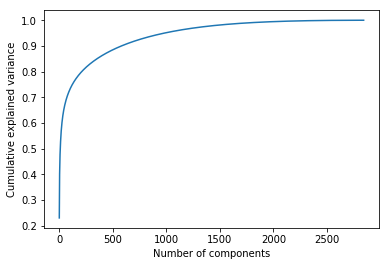

In [105]:
train_data_list, test_data_list = pca(train_data_list, test_data_list)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model:  one Class SVM
Train accuracy: 0.8994020400984876
Test accuracy: 0.6653730056058645


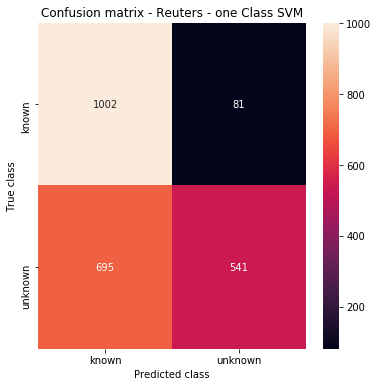

              precision    recall  f1-score   support

          -1       0.87      0.44      0.58      1236
           1       0.59      0.93      0.72      1083

    accuracy                           0.67      2319
   macro avg       0.73      0.68      0.65      2319
weighted avg       0.74      0.67      0.65      2319



In [106]:
svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
y_pred_train = svm_model.predict(train_data_list)
y_pred_test = svm_model.predict(test_data_list)
results('one Class SVM', final_train['new_label'].tolist(), y_pred_train, final_test['new_label'].tolist(), y_pred_test)

In [26]:
#train_scores_svm = svm_model.decision_function(train_data_list)
#test_scores_svm = svm_model.decision_function(test_data_list)
#print(train_scores)

Model:  Isolation Forest
Train accuracy: 0.9296517762926486
Test accuracy: 0.7313497197067702


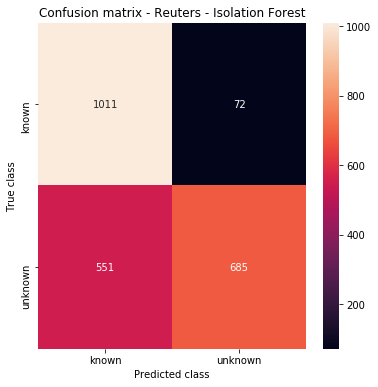

              precision    recall  f1-score   support

          -1       0.90      0.55      0.69      1236
           1       0.65      0.93      0.76      1083

    accuracy                           0.73      2319
   macro avg       0.78      0.74      0.73      2319
weighted avg       0.78      0.73      0.72      2319



In [88]:
rand_state = np.random.RandomState(42)
iso_forest = isolationForest(train_data_list, rand_state)
y_pred_iso_train = iso_forest.predict(train_data_list)
y_pred_iso_test = iso_forest.predict(test_data_list)
results('Isolation Forest', final_train['new_label'].tolist(), y_pred_iso_train, final_test['new_label'].tolist(), y_pred_iso_test)

Model:  Local Outlier Factory
Train accuracy: 0.9004572634540978
Test accuracy: 0.7248814144027598


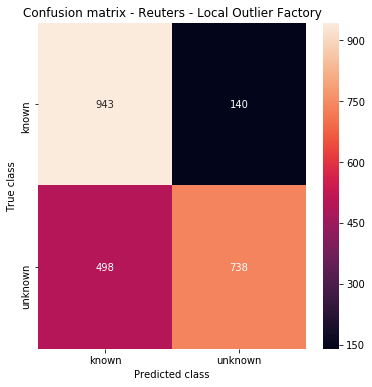

              precision    recall  f1-score   support

          -1       0.84      0.60      0.70      1236
           1       0.65      0.87      0.75      1083

    accuracy                           0.72      2319
   macro avg       0.75      0.73      0.72      2319
weighted avg       0.75      0.72      0.72      2319



In [89]:
lof = local_outlier_factory(train_data_list, 1000)
y_pred_lof_train = lof.predict(train_data_list)
y_pred_lof_test = lof.predict(test_data_list)
results('Local Outlier Factory', final_train['new_label'].tolist(), y_pred_lof_train, final_test['new_label'].tolist(), y_pred_lof_test)

In [19]:
train_data_df = webkb_train_dataset()
test_data_df = webkb_test_dataset()

In [20]:
def data_for_autoencoder():                 
    # Numerical Labeling : 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == 'student', 'new_label'] = 0
    train_data_df.loc[train_data_df['label'] != 'student', 'new_label'] = 1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == 'student', 'new_label'] = 0
    test_data_df.loc[test_data_df['label'] != 'student', 'new_label'] = 1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 0]
    print(final_train['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test

In [21]:
final_train, final_test = data_for_autoencoder()

0    1096
Name: new_label, dtype: int64
1    852
0    543
Name: new_label, dtype: int64


In [110]:
# Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
#train_data_list, test_data_list = use_embeddings()
#train_data_list, test_data_list = bert_embeddings()
train_data_list, test_data_list = infersent_embeddings()
#train_data_list, test_data_list = elmo_embeddings()
#train_data_list, test_data_list = other_embeddings('glove')

Vocab size : 100000
Nb words kept : 121442/140578 (86.4%)
Speed : 66.7 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 2843
Nb words kept : 135786/154744 (87.7%)
Speed : 57.5 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 2319


In [111]:
X_train = train_data_list
y_train = final_train['new_label'].tolist()
X_test = test_data_list
y_test = final_test['new_label'].tolist()

In [112]:
input_dim = X_train.shape[1]
encoding_dim = 14
nb_epoch = 100
batch_size = 32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_reuters.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs_reuters',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 2843 samples, validate on 2319 samples
Epoch 1/100
2843/2843 [==============================] - 1s 323us/step - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0039 - val_accuracy: 0.0082
Epoch 2/100
2843/2843 [==============================] - 1s 223us/step - loss: 0.0032 - accuracy: 0.0820 - val_loss: 0.0040 - val_accuracy: 0.0276
Epoch 3/100
2843/2843 [==============================] - 1s 229us/step - loss: 0.0031 - accuracy: 0.0447 - val_loss: 0.0036 - val_accuracy: 0.0276
Epoch 4/100
2843/2843 [==============================] - 1s 222us/step - loss: 0.0029 - accuracy: 0.0510 - val_loss: 0.0037 - val_accuracy: 0.0673
Epoch 5/100
2843/2843 [==============================] - 1s 222us/step - loss: 0.0029 - accuracy: 0.0735 - val_loss: 0.0035 - val_accuracy: 0.0530
Epoch 6/100
2843/2843 [==============================] - 1s 224us/step - loss: 0.0028 - accuracy: 0.0841 - val_loss: 0.0036 - val_accuracy: 0.0565
Epoch 7/100
2843/2843 [==============================] - 1s 223us/

2843/2843 [==============================] - 1s 224us/step - loss: 0.0023 - accuracy: 0.3067 - val_loss: 0.0029 - val_accuracy: 0.2277
Epoch 57/100
2843/2843 [==============================] - 1s 227us/step - loss: 0.0022 - accuracy: 0.3303 - val_loss: 0.0029 - val_accuracy: 0.2687
Epoch 58/100
2843/2843 [==============================] - 1s 220us/step - loss: 0.0022 - accuracy: 0.3236 - val_loss: 0.0029 - val_accuracy: 0.1841
Epoch 59/100
2843/2843 [==============================] - 1s 226us/step - loss: 0.0021 - accuracy: 0.3380 - val_loss: 0.0028 - val_accuracy: 0.1953
Epoch 60/100
2843/2843 [==============================] - 1s 227us/step - loss: 0.0022 - accuracy: 0.3292 - val_loss: 0.0029 - val_accuracy: 0.2234
Epoch 61/100
2843/2843 [==============================] - 1s 218us/step - loss: 0.0021 - accuracy: 0.3299 - val_loss: 0.0028 - val_accuracy: 0.2040
Epoch 62/100
2843/2843 [==============================] - 1s 227us/step - loss: 0.0022 - accuracy: 0.3130 - val_loss: 0.0033 

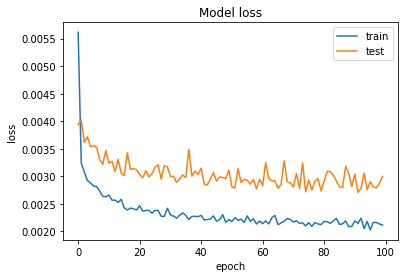

In [113]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [114]:
#Load the model for prediction
autoencoder = load_model('model_reuters.h5')
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,2319.000000,2319.000000
mean,0.001814,0.532988
std,0.000573,0.499018
min,0.000624,0.000000
25%,0.001413,0.000000
50%,0.001775,1.000000
75%,0.002164,1.000000
max,0.004626,1.000000


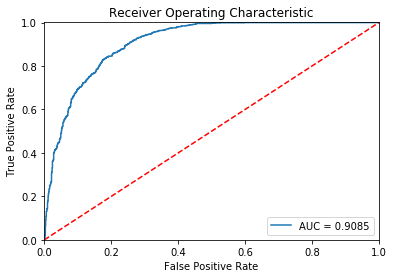

In [115]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

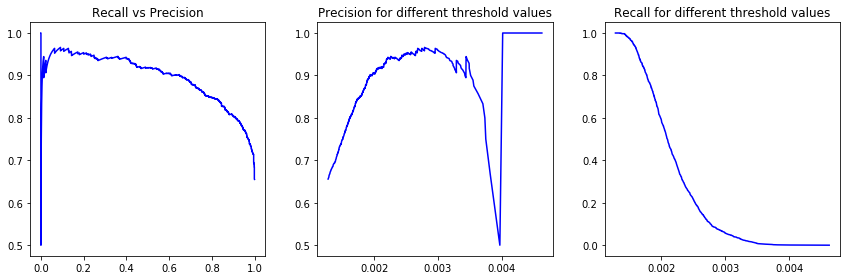

In [116]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
#plt.plot(recall, precision, 'b', label='Precision-Recall curve')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].plot(recall, precision, 'b', label='Precision-Recall curve')
axes[0].set_title('Recall vs Precision')
axes[1].plot(th, precision[1:], 'b', label='Threshold-Precision curve')
axes[1].set_title('Precision for different threshold values')
axes[2].plot(th, recall[1:], 'b', label='Threshold-Recall curve')
axes[2].set_title('Recall for different threshold values')
fig.tight_layout()

Maximum Test accuracy: 0.8275096594321778
Threshold for maximal accuracy:  0.0017183068


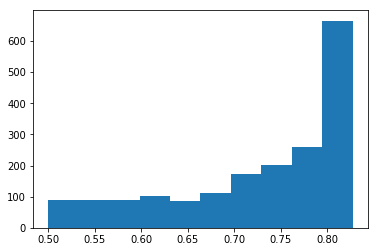

In [117]:
accuracies = []
for threshold in th:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    accuracies.append(balanced_accuracy_score(error_df.true_class, y_pred))
print("Maximum Test accuracy:", max(accuracies))
#print(accuracies.index(max(accuracies)))
print('Threshold for maximal accuracy: ', th[accuracies.index(max(accuracies))])
threshold = th[accuracies.index(max(accuracies))]
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(accuracies)

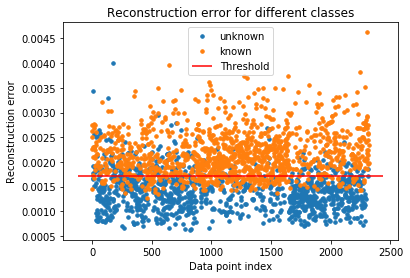

In [118]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "known" if name == 1 else "unknown")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Test accuracy: 0.8275096594321778


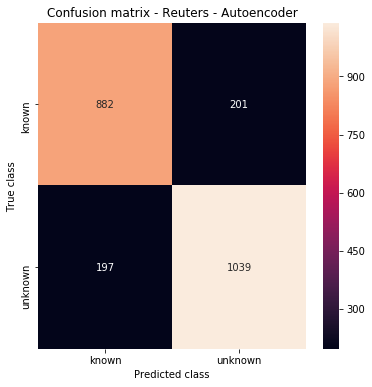

In [119]:
LABELS = ["known", "unknown"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred,[0,1])
print("Test accuracy:", balanced_accuracy_score(error_df.true_class, y_pred))
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Reuters - Autoencoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Base individual models end. Ensemble approaches begin from here

In [ ]:
y_pred_cvdd = [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
for elem in y_pred_cvdd:
    if elem == 1.0:
        elem = -1
    if elem == 0.0:
        elem = 1
print(len(y_pred_cvdd))

In [24]:
import math as mt
def mostFrequent(arr): 
    n = len(arr)
    # Insert all elements in Hash. 
    Hash = dict() 
    for i in range(n): 
        if arr[i] in Hash.keys(): 
            Hash[arr[i]] += 1
        else: 
            Hash[arr[i]] = 1
  
    # find the max frequency 
    max_count = 0
    res = -1
    for i in Hash:  
        if (max_count < Hash[i]):  
            res = i 
            max_count = Hash[i] 
          
    return res  

y_pred_train_ensemble = []
for i in range(len(final_train['new_label'].tolist())):
    train_arr = [ y_pred_train[i], y_pred_iso_train[i], y_pred_lof_train[i]]
    y_pred_train_ensemble.append(mostFrequent(train_arr))

y_pred_test_ensemble = []

for i in range(len(final_test['new_label'].tolist())):
    arr = [ y_pred_test[i], y_pred_iso_test[i], y_pred_lof_test[i]]
    y_pred_test_ensemble.append(mostFrequent(arr))

results('Ensemble', final_train['new_label'].tolist(), y_pred_train_ensemble, final_test['new_label'].tolist(), y_pred_test_ensemble)

Model:  Ensemble
Train accuracy: 0.90889905029898
Test accuracy: 0.7960327727468737
Confusion Matrix :
[[1049  187]
 [ 286  797]]
Report : 
              precision    recall  f1-score   support

          -1       0.79      0.85      0.82      1236
           1       0.81      0.74      0.77      1083

   micro avg       0.80      0.80      0.80      2319
   macro avg       0.80      0.79      0.79      2319
weighted avg       0.80      0.80      0.80      2319



In [137]:
!pip install pyod

In [138]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print

In [139]:
print(np.asarray(train_scores_svm).shape)
print(np.asarray(train_scores_iso).shape)

(2843,)
(2843,)


In [140]:
#train_svm = np.asarray(train_scores_svm)
#train_iso = np.asarray(train_scores_iso)
#trian_lof = np.asarray(train_scores_lof)
#print(type(train_svm))
new_arr_train = np.array((train_scores_svm, train_scores_iso, train_scores_lof)).transpose()
new_arr_test = np.array((test_scores_svm, test_scores_iso, test_scores_lof)).transpose()

In [141]:
train_comb_norm_score, test_comb_norm_score = standardizer(new_arr_train, new_arr_test)

In [142]:
print('Decision score matrix on training data', train_comb_norm_score.shape)
print('Decision score matrix on test data', test_comb_norm_score.shape)

Decision score matrix on training data (2843, 3)
Decision score matrix on test data (2319, 3)


In [152]:
y_by_average = average(test_comb_norm_score)
print(y_by_average)

[-3.93943873 -1.29036037 -4.31189133 ... -4.68175393 -1.56291396
 -5.11085877]


In [150]:
 #Combine and evaluate the combination result

# Combination by average
y_by_average = average(test_comb_norm_score)
evaluate_print('Combination by Average', np.asarray(final_test['new_label'].tolist()), y_by_average)

# Combination by max
y_by_maximization = maximization(test_comb_norm_score)
evaluate_print('Combination by Maximization', np.asarray(final_test['new_label'].tolist()), y_by_maximization)

# Combination by aom
y_by_aom = aom(test_comb_norm_score, n_buckets=5)
evaluate_print('Combination by AOM', np.asarray(final_test['new_label'].tolist()), y_by_aom)

# Combination by moa
y_by_moa = moa(test_comb_norm_score, n_buckets=5)
evaluate_print('Combination by MOA', np.asarray(final_test['new_label'].tolist()), y_by_moa)

ValueError: n_buckets is set to 5. Not in the range of (2, 3).

In [48]:
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

In [50]:
# Define data file and read X and y
# Generate some data if the source data is missing
mat_file = "/opt/notebooks/datasets/cardio.mat"

try:
    mat = loadmat(os.path.join('data', mat_file))

except TypeError:
    print('{data_file} does not exist. Use generated data'.format(
        data_file=mat_file))
    X, y = generate_data(train_only=True)  # load data
except IOError:
    print('{data_file} does not exist. Use generated data'.format(
        data_file=mat_file))
    X, y = generate_data(train_only=True)  # load data
else:
    X = mat['X']
    y = mat['y'].ravel()
    
# 60% data for training and 40% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

In [51]:
print("Training data:", X_train.shape, y_train.shape)
print("Test data:", X_test.shape, y_test.shape)

Training data: (1098, 21) (1098,)
Test data: (733, 21) (733,)


In [80]:
n_clf = 3  # number of base detectors

# Initialize 20 base detectors for combination
k_list = [10, 20, 30]

train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

print('Initializing {n_clf} kNN detectors'.format(n_clf=n_clf))

for i in range(n_clf):
    k = k_list[i]

    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm)
    print('Base detector %i is fitted for prediction' % i)

Initializing 3 kNN detectors
Base detector 0 is fitted for prediction
Base detector 1 is fitted for prediction
Base detector 2 is fitted for prediction


In [81]:
print(train_scores)

[[ 3.69208192  4.38328452  4.81733332]
 [ 2.85450319  3.42625343  3.5660118 ]
 [ 1.36752874  1.73222743  1.95846519]
 ...
 [12.69518642 13.18103592 13.41138958]
 [ 2.56129355  2.79405191  2.97747515]
 [ 1.93667029  2.08701298  2.25876142]]


In [62]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,
                                                   test_scores)

# Predicted scores from all base detectors on the test data is 
# stored in train_scores_norm and test_scores_norm
print('Decision score matrix on training data', train_scores_norm.shape)
print('Decision score matrix on test data', test_scores_norm.shape)

Decision score matrix on training data (1098, 20)
Decision score matrix on test data (733, 20)


In [69]:
# Combine and evaluate the combination result

# Combination by average
y_by_average = average(test_scores_norm)
evaluate_print('Combination by Average', y_test, y_by_average)

# Combination by max
y_by_maximization = maximization(test_scores_norm)
evaluate_print('Combination by Maximization', y_test, y_by_maximization)

# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
evaluate_print('Combination by AOM', y_test, y_by_aom)

# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)
evaluate_print('Combination by MOA', y_test, y_by_moa)

Combination by Average ROC:0.9232, precision @ rank n:0.5325
Combination by Maximization ROC:0.9238, precision @ rank n:0.5584
Combination by AOM ROC:0.9304, precision @ rank n:0.5714
Combination by MOA ROC:0.9266, precision @ rank n:0.5455


In [70]:
print(y_test.shape)
print(y_by_average.shape)

(733,)
(733,)


In [67]:
print(np.asarray(final_test['new_label'].tolist()).shape)

(2319,)
